In this analysis, I aim to uncover patterns in victim characteristics by various attributes (law category, age group, race, and sex) within a specific geographic region. The key steps involved are:

Summary of Steps:
1. Load the NYPD complaint data into a DataFrame.
2. Filter and preprocess data for analysis:
   - Focus on crime data from Brooklyn for January 2024.
   - Handle missing data and categorize victim age groups.
3. Normalize numerical columns and convert categorical variables using one-hot encoding.
4. Determine the optimal number of clusters (k) using the Elbow Method.
5. Perform KMeans clustering on the preprocessed data.
6. Visualize the geographical distribution of clusters.
7. Cluster Comparison: Calculate and plot the percentage distributions of categorical attributes by cluster.
8. Generate pie charts for each cluster and save them as HTML files.
9. Create an interactive Folium map with markers colored by cluster and popups linking to pie chart details.

In [ ]:
the result indicate that: there are 6 ckluster for victim in Brooklyn for January 2024. 

In [53]:
# pip install folium
# pip install mpld3

In [54]:
'''
Explore and visualize NYPD complaint data for Brooklyn, focusing on clustering and crime statistics.
Data source: https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Current-Year-To-Date-/5uac-w243
'''

import pandas as pd
import matplotlib.pyplot as plt
import folium
import mpld3
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.ticker as mtick
import os

1. Load the NYPD complaint data into a DataFrame.
2. Filter and preprocess data for analysis:
   - Focus on crime data from Brooklyn for January 2024.
   - Handle missing data and categorize victim age groups.

In [55]:
# URL of the CSV data
url = 'https://data.cityofnewyork.us/resource/5uac-w243.csv?$limit=500000'

# Load data into DataFrame
df = pd.read_csv(url, low_memory=False)

# Ensure the directory exists
output_dir = 'nypd-data_visuals'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Filter and preprocess data for analysis
df['rpt_dt'] = pd.to_datetime(df['rpt_dt'])

# use only data from 2024 January and Brooklyn, can be changed to any other month and borough
focus_year = 2024
focus_month = 1
focus_borough = 'BROOKLYN'

focal_crime_vic = df[(df['rpt_dt'].dt.year == focus_year) & (df['rpt_dt'].dt.month == focus_month) & (df['boro_nm'] == focus_borough)]

columns_to_cluster = ['latitude', 'longitude', 'law_cat_cd', 'vic_age_group', 'vic_race', 'vic_sex']
focal_crime_vic.dropna(subset=columns_to_cluster, inplace=True)

/var/folders/t5/q2z04b350s799632zl5nt45r0000gn/T/ipykernel_1744/689113128.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  focal_crime_vic.dropna(subset=columns_to_cluster, inplace=True)


3. Normalize numerical columns and convert categorical variables using one-hot encoding.

In [56]:

focal_crime_vic.loc[:, 'vic_age_group'] = focal_crime_vic['vic_age_group'].apply(lambda x: x if x in ['<18', '18-24', '25-44', '45-64', '65+'] else 'UNKNOWN')
# Normalize numerical columns
scaler = StandardScaler()
X = focal_crime_vic[columns_to_cluster].copy()
X[['latitude', 'longitude']] = scaler.fit_transform(X[['latitude', 'longitude']])
X = pd.get_dummies(X, columns=['law_cat_cd', 'vic_age_group', 'vic_race', 'vic_sex'])


4. Determine the optimal number of clusters (k) using the Elbow Method.

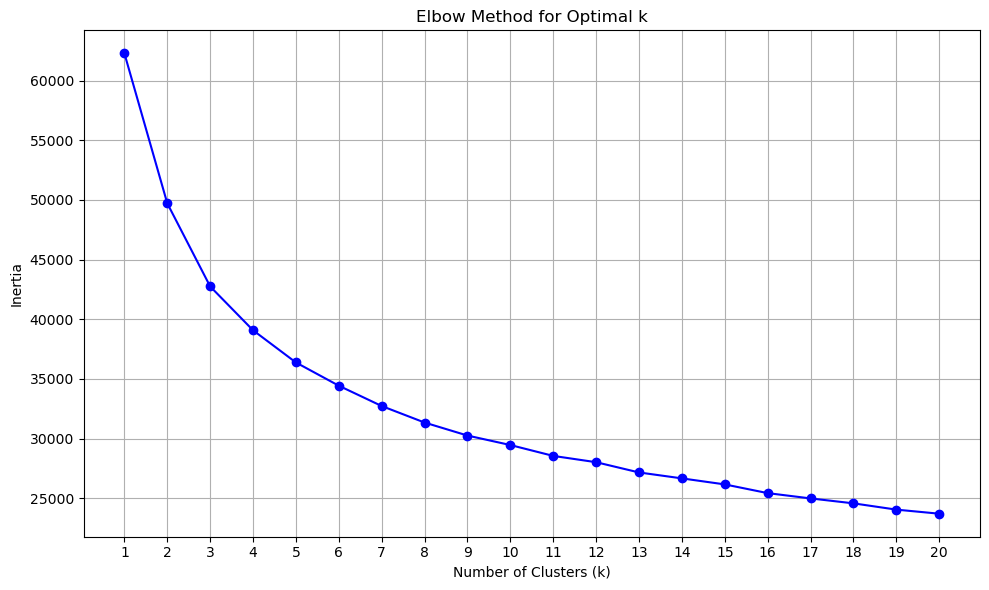

In [57]:
# Determine the optimal number of clusters (k) using the Elbow Method
k_range = range(1, 21)
inertia = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.xticks(k_range)
plt.tight_layout()
plt.show()



In [58]:
# Selecting k = 6 based on the Elbow Method and clustering data
k = 6

5. Perform KMeans clustering on the preprocessed data.

In [59]:
kmeans = KMeans(n_clusters=k, random_state=42)
focal_crime_vic['cluster'] = kmeans.fit_predict(X)
focal_crime_vic['cluster'] = focal_crime_vic['cluster'].apply(lambda x: x + 1)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/t5/q2z04b350s799632zl5nt45r0000gn/T/ipykernel_1744/588118363.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  focal_crime_vic['cluster'] = kmeans.fit_predict(X)
/var/folders/t5/q2z04b350s799632zl5nt45r0000gn/T/ipykernel_1744/588118363.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

6. Visualize the geographical distribution of clusters.

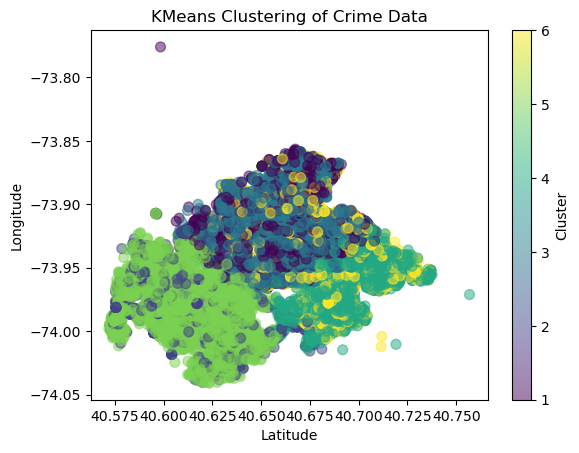

In [60]:
# Plotting geographical distribution of clusters
plt.scatter(focal_crime_vic['latitude'], focal_crime_vic['longitude'], c=focal_crime_vic['cluster'], cmap='viridis', s=50, alpha=0.5)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('KMeans Clustering of Crime Data')
plt.colorbar(label='Cluster')
plt.show()

7. Cluster comparison: Calculate and plot the percentage distributions of categorical attributes by cluster.

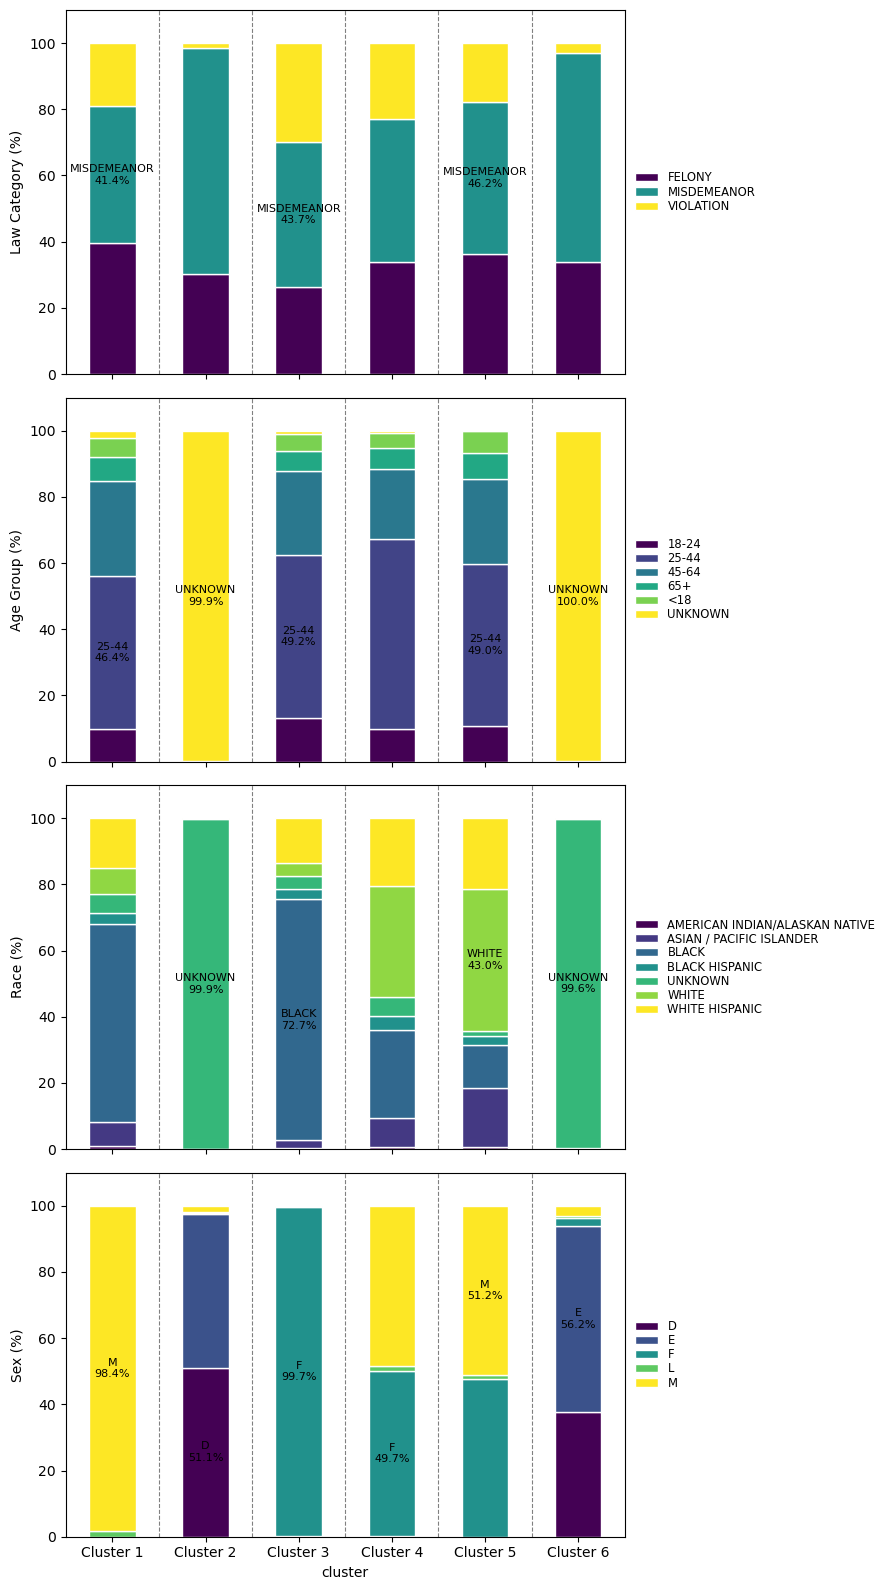

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming focal_crime_vic DataFrame is already created and contains the necessary data

# Function to calculate percentage distributions
def calculate_percentage(x):
    return (x.value_counts() / len(x)) * 100

# Calculating percentage distributions by cluster for categorical attributes
law_cat_cd_perc = focal_crime_vic.groupby('cluster')['law_cat_cd'].apply(calculate_percentage).unstack()
vic_age_group_perc = focal_crime_vic.groupby('cluster')['vic_age_group'].apply(calculate_percentage).unstack()
vic_race_perc = focal_crime_vic.groupby('cluster')['vic_race'].apply(calculate_percentage).unstack()
vic_sex_perc = focal_crime_vic.groupby('cluster')['vic_sex'].apply(calculate_percentage).unstack()

# Plotting stacked bar charts for categorical distributions by cluster
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 16), sharex=True)

def annotate_major_category(ax, df):
    for cluster in df.index:
        max_category = df.loc[cluster].idxmax()
        max_value = df.loc[cluster].max()
        # Find the patch corresponding to the max category
        for patch in ax.patches:
            if patch.get_height() == max_value:
                ax.annotate(f'{max_category}\n{max_value:.1f}%', 
                            (patch.get_x() + patch.get_width() / 2, patch.get_y() + patch.get_height() / 2),
                            ha='center', va='center', fontsize=8, color='black')

# Plotting and customizing each subplot
law_cat_cd_perc.plot(kind='bar', stacked=True, ax=axes[0], colormap='viridis', edgecolor='white')
vic_age_group_perc.plot(kind='bar', stacked=True, ax=axes[1], colormap='viridis', edgecolor='white')
vic_race_perc.plot(kind='bar', stacked=True, ax=axes[2], colormap='viridis', edgecolor='white')
vic_sex_perc.plot(kind='bar', stacked=True, ax=axes[3], colormap='viridis', edgecolor='white')

# Annotate each bar chart with the majority category and percentage
annotate_major_category(axes[0], law_cat_cd_perc)
annotate_major_category(axes[1], vic_age_group_perc)
annotate_major_category(axes[2], vic_race_perc)
annotate_major_category(axes[3], vic_sex_perc)

# Add y-axis labels for each subplot
axes[0].set_ylabel('Law Category (%)')
axes[1].set_ylabel('Age Group (%)')
axes[2].set_ylabel('Race (%)')
axes[3].set_ylabel('Sex (%)')

# Set the x-axis labels to the cluster numbers
axes[3].set_xticks(range(len(law_cat_cd_perc.index)))
axes[3].set_xticklabels([f'Cluster {cluster}' for cluster in law_cat_cd_perc.index], rotation=0)

# Add vertical lines between clusters
for ax in axes:
    for pos in range(1, len(law_cat_cd_perc.index)):
        ax.axvline(x=pos - 0.5, color='grey', linestyle='--', linewidth=0.8)

# Adjusting legend position and size
for ax in axes:
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small', frameon=False, labelspacing=0.1)
    ax.margins(y=0.1)  # Add some margins to ensure text is not cut off

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

8. Generate pie charts for each cluster and save them as HTML files.

In [62]:
def plot_cluster_pies(cluster_df, cluster_num):
    attributes = ['law_cat_cd', 'vic_age_group', 'vic_race', 'vic_sex']
    cluster_data = cluster_df[cluster_df['cluster'] == cluster_num]
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))  # Reduced figure size

    for i, attr in enumerate(attributes):
        row = i // 2
        col = i % 2

        attr_counts = cluster_data[attr].value_counts()
        axes[row, col].pie(attr_counts, labels=attr_counts.index, autopct='%1.1f%%', startangle=140)
        axes[row, col].set_title(f'{attr} Distribution in Cluster {cluster_num}')
        axes[row, col].axis('equal')

    fig.tight_layout()
    # plt.show()
    html_str = mpld3.fig_to_html(plt.gcf())
    with open(f'{output_dir}/cluster_{cluster_num}_pies.html', 'w') as f:
        f.write(html_str)
    plt.close()

# Generate pie chart HTML files for each cluster
num_clusters = focal_crime_vic['cluster'].nunique()
for cluster_num in range(1, num_clusters + 1):
    plot_cluster_pies(focal_crime_vic, cluster_num)

In [63]:
# Create Folium map with markers colored by cluster and popups linking to pie chart details
brooklyn_center = [40.65, -73.95]
m = folium.Map(location=brooklyn_center, zoom_start=12)

# The original dataset is too large to load all data points on the map at once. 
# Therefore, a sample of 5000 data points was used to create the visualization. 
# Sample 5000 data points if more than 5000 rows are available
focal_crime_vic_sample = focal_crime_vic.sample(n=5000) if len(focal_crime_vic) > 5000 else focal_crime_vic


for index, row in focal_crime_vic_sample.iterrows():
    lat, lon = row['latitude'], row['longitude']
    cluster_label = row['cluster']
    color = 'blue' if cluster_label == 1 else 'green' if cluster_label == 2 else 'red' if cluster_label == 3 else \
        'purple' if cluster_label == 4 else 'orange' if cluster_label == 5 else 'black'
    popup_content = f'<a href="{output_dir}/cluster_{cluster_label}_pies.html" target="_blank">Cluster {cluster_label} Details</a>'
    folium.Marker([lat, lon], popup=popup_content, icon=folium.Icon(color=color)).add_to(m)

m.save(f'{output_dir}/cluster_map.html')

# Map Visualization Result

You can see the result of the map by checking the `cluster_map.html` file in the `nypd-data_visuals` folder. Hover over the markers on the map to see hyperlinks to detailed pie charts for each cluster. 

Below is a sample image of the generated map.


<img src="nypd-data_visuals/sample_map_image.png" alt="NYPD Data Visuals" width="500"/>

# Cluster Summary

| Cluster | Majority Law Category                | Majority Age Group             | Majority Race   | Majority Sex                  |
|---------|--------------------------------------|--------------------------------|-----------------|-------------------------------|
| 1       | Relatively high felony               |                                | High BLACK      | 99% M                         |
| 2       | Mostly MISDEMEANOR and felony        | All UNKNOWN                    | All UNKNOWN     | NON binary or unidentified    |
| 3       |                                      |                                | High BLACK      | 99% F                         |
| 4       |                                      | High % in 25-44 age group      |                 |                               |
| 5       | Mostly MISDEMEANOR                   |                                | Relatively high in white |                               |
| 6       | Mostly MISDEMEANOR and felony        | All UNKNOWN                    | All UNKNOWN     | NON binary or unidentified    |

## Geographic Summary

- **Cluster 1 (Blue)**: Northern East Brooklyn, characterized by a relatively high number of felonies, predominantly affecting Black male victims.
- **Cluster 2 (Green)**: South-West Brooklyn, characterized by mostly misdemeanors and felonies, with victims predominantly unidentified sex groups, could be LGBT.
- **Cluster 3 (Red)**: Northern East Brooklyn, characterized by a high proportion of Black female victims.
- **Cluster 4 (Purple)**: Northern Brooklyn, with a significant presence of victims aged 25-44.
- **Cluster 5 (Orange)**: South-West Brooklyn, predominantly characterized by misdemeanors and a relatively high number of white victims.
- **Cluster 6 (Black)**: Overlaps with Clusters 1, 3, and 4, characterized by mostly misdemeanors and felonies, with victims predominantly unidentified sex groups.